<a href="https://colab.research.google.com/github/PLivdan/Notebooks/blob/main/NEAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Set, Tuple, Optional
import random
from collections import defaultdict

@dataclass(frozen=True)
class NodeGene:
    id: int
    type: str  # 'input', 'hidden', 'output'
    activation: str = 'tanh'
    x: float = None  # For visualization
    y: float = None

@dataclass(frozen=True)
class ConnectionGene:
    in_node: int
    out_node: int
    weight: float
    enabled: bool = True
    innovation: int = None

class Genome:
    def __init__(self, nodes: Dict[int, NodeGene], connections: Dict[Tuple[int, int], ConnectionGene], fitness: float = 0.0):
        self.nodes = nodes
        self.connections = connections
        self.fitness = fitness

    def get_layers(self) -> Dict[int, Set[int]]:
        """Returns node layers for feedforward evaluation."""
        layers = defaultdict(set)
        processed = set()

        # Add input nodes to layer 0
        input_nodes = {n.id for n in self.nodes.values() if n.type == 'input'}
        layers[0] = input_nodes
        processed.update(input_nodes)

        # Process nodes whose inputs have all been processed
        layer = 1
        while len(processed) < len(self.nodes):
            layer_nodes = set()
            for node_id in self.nodes:
                if node_id in processed: continue

                input_connections = {c.in_node for c in self.connections.values()
                                  if c.out_node == node_id and c.enabled}

                if all(in_node in processed for in_node in input_connections):
                    layer_nodes.add(node_id)

            if not layer_nodes:  # Circuit detected
                raise ValueError("Cyclic connections detected in genome")

            layers[layer] = layer_nodes
            processed.update(layer_nodes)
            layer += 1

        return layers

    def feedforward(self, inputs: np.ndarray) -> np.ndarray:
        """Evaluates the neural network defined by this genome."""
        if len(inputs) != len([n for n in self.nodes.values() if n.type == 'input']):
            raise ValueError("Invalid input dimension")

        # Initialize activations
        activations = {}
        input_nodes = [n.id for n in self.nodes.values() if n.type == 'input']
        for val, node_id in zip(inputs, input_nodes):
            activations[node_id] = val

        # Get evaluation layers
        layers = self.get_layers()

        # Process each layer
        for layer in range(1, len(layers)):
            for node_id in layers[layer]:
                # Sum incoming connections
                incoming = sum(
                    self.connections[in_node, node_id].weight * activations[in_node]
                    for in_node in layers[layer-1]
                    if (in_node, node_id) in self.connections
                    and self.connections[in_node, node_id].enabled
                )
                activations[node_id] = np.tanh(incoming)

        # Return outputs in order
        output_nodes = [n.id for n in self.nodes.values() if n.type == 'output']
        return np.array([activations[node_id] for node_id in output_nodes])

# Test Implementation
nodes = {
    0: NodeGene(0, 'input', x=0.0, y=0.0),
    1: NodeGene(1, 'input', x=0.0, y=1.0),
    2: NodeGene(2, 'hidden', x=0.5, y=0.5),
    3: NodeGene(3, 'output', x=1.0, y=0.5)
}

connections = {
    (0, 2): ConnectionGene(0, 2, 0.5),
    (1, 2): ConnectionGene(1, 2, 0.5),
    (2, 3): ConnectionGene(2, 3, 0.5)
}

genome = Genome(nodes, connections)

# Test Results
test_inputs = [
    np.array([0., 0.]),
    np.array([0., 1.]),
    np.array([1., 0.]),
    np.array([1., 1.])
]

print("XOR Network Test Results:")
for inp in test_inputs:
    output = genome.feedforward(inp)
    print(f"Input: {inp}, Output: {output}")

# Network layer analysis
layers = genome.get_layers()
print("\nNetwork Layers:")
for layer_num, node_ids in layers.items():
    print(f"Layer {layer_num}: {node_ids}")

XOR Network Test Results:
Input: [0. 0.], Output: [0.]
Input: [0. 1.], Output: [0.22703261]
Input: [1. 0.], Output: [0.22703261]
Input: [1. 1.], Output: [0.36339948]

Network Layers:
Layer 0: {0, 1}
Layer 1: {2}
Layer 2: {3}


In [19]:
class InnovationTracker:
    def __init__(self):
        self.innovation_number = 0
        self.innovations = {}  # (in_node, out_node) -> innovation_number

    def get_innovation(self, in_node: int, out_node: int) -> int:
        key = (in_node, out_node)
        if key not in self.innovations:
            self.innovations[key] = self.innovation_number
            self.innovation_number += 1
        return self.innovations[key]

class MutationParams:
    def __init__(self,
                 weight_mutation_rate=0.8,
                 weight_perturbation_rate=0.9,
                 new_node_rate=0.03,
                 new_connection_rate=0.05,
                 weight_init_range=2.0):
        self.__dict__.update(locals())
        # Add adaptive parameters
        self.min_rate = 0.01
        self.max_rate = 0.95
        self.adaptation_rate = 0.1

class Mutator:
    def __init__(self, innovation_tracker: InnovationTracker, params: MutationParams):
        self.innovation_tracker = innovation_tracker
        self.params = params
        # Track mutation success
        self.weight_success = 0
        self.weight_attempts = 0
        self.node_success = 0
        self.node_attempts = 0
        self.conn_success = 0
        self.conn_attempts = 0

    def mutate_weights(self, genome: Genome) -> Genome:
        """Returns new genome with mutated weights using improved distribution."""
        new_connections = {}
        mutations_made = False

        for key, conn in genome.connections.items():
            if random.random() < self.params.weight_mutation_rate:
                if random.random() < self.params.weight_perturbation_rate:
                    # Use Cauchy distribution for occasional large jumps
                    perturbation = np.random.standard_cauchy() * self.params.weight_init_range / 10
                    new_weight = conn.weight + perturbation
                else:
                    # Mix of uniform and normal distributions
                    if random.random() < 0.8:
                        new_weight = random.uniform(-self.params.weight_init_range, self.params.weight_init_range)
                    else:
                        new_weight = random.gauss(0, self.params.weight_init_range / 2)

                new_connections[key] = ConnectionGene(
                    conn.in_node, conn.out_node, new_weight, conn.enabled, conn.innovation)
                mutations_made = True
            else:
                new_connections[key] = conn

        # Update statistics
        self.weight_attempts += 1
        if mutations_made:
            self.weight_success += 1

        return Genome(genome.nodes.copy(), new_connections, genome.fitness)

    def add_node(self, genome: Genome) -> Genome:
        """Returns new genome with an added node using improved selection."""
        if not genome.connections:
            return genome

        self.node_attempts += 1

        # Copy existing structure
        new_nodes = genome.nodes.copy()
        new_connections = genome.connections.copy()

        # Select connection based on weight magnitude
        enabled_conns = [(c, abs(c.weight)) for c in genome.connections.values() if c.enabled]
        if not enabled_conns:
            return genome

        # Weight selection by connection strength
        weights = [w for _, w in enabled_conns]
        old_conn = random.choices(enabled_conns, weights=weights)[0][0]

        # Disable old connection
        new_connections[(old_conn.in_node, old_conn.out_node)] = ConnectionGene(
            old_conn.in_node, old_conn.out_node, old_conn.weight,
            enabled=False, innovation=old_conn.innovation)

        # Create new node with slight position randomization
        new_node_id = max(genome.nodes.keys()) + 1

        # Add small random offset for variety
        offset_x = random.gauss(0, 0.1)
        offset_y = random.gauss(0, 0.1)

        split_x = (genome.nodes[old_conn.in_node].x + genome.nodes[old_conn.out_node].x) / 2 + offset_x
        split_y = (genome.nodes[old_conn.in_node].y + genome.nodes[old_conn.out_node].y) / 2 + offset_y

        # Keep coordinates in bounds
        split_x = max(0.1, min(0.9, split_x))
        split_y = max(0.1, min(0.9, split_y))

        new_nodes[new_node_id] = NodeGene(new_node_id, 'hidden', x=split_x, y=split_y)

        # Add new connections
        in_innovation = self.innovation_tracker.get_innovation(old_conn.in_node, new_node_id)
        out_innovation = self.innovation_tracker.get_innovation(new_node_id, old_conn.out_node)

        # Improved weight initialization
        in_weight = 1.0  # Preserve activation
        out_weight = old_conn.weight  # Preserve original behavior

        new_connections[(old_conn.in_node, new_node_id)] = ConnectionGene(
            old_conn.in_node, new_node_id, in_weight, True, in_innovation)
        new_connections[(new_node_id, old_conn.out_node)] = ConnectionGene(
            new_node_id, old_conn.out_node, out_weight, True, out_innovation)

        self.node_success += 1
        return Genome(new_nodes, new_connections, genome.fitness)

    def _would_create_cycle(self, genome: Genome, in_node: int, out_node: int) -> bool:
        """Check if adding a connection would create a cycle."""
        # Start from the output node and traverse backwards
        visited = set()
        to_visit = {out_node}

        while to_visit:
            current = to_visit.pop()
            visited.add(current)

            # Find all nodes that connect to this node
            incoming = {conn.in_node for conn in genome.connections.values()
                       if conn.out_node == current and conn.enabled}

            # If we find our input node, it means there's already a path
            # from out_node to in_node, so adding in_node -> out_node would create a cycle
            if in_node in incoming:
                return True

            # Add unvisited incoming nodes to check
            to_visit.update(node for node in incoming if node not in visited)

        return False

    def add_connection(self, genome: Genome) -> Genome:
        """Returns new genome with an added connection using improved selection."""
        # Get all possible connections with layer analysis
        layers = genome.get_layers()
        possible_connections = []

        for i in range(len(layers)-1):
            for in_node in layers[i]:
                for j in range(i+1, len(layers)):
                    for out_node in layers[j]:
                        if ((in_node, out_node) not in genome.connections and
                            not self._would_create_cycle(genome, in_node, out_node)):
                            # Calculate connection score
                            score = self._calculate_connection_score(genome, in_node, out_node)
                            possible_connections.append(((in_node, out_node), score))

        if not possible_connections:
            return genome

        # Select connection based on scores
        connections, scores = zip(*possible_connections)
        chosen_connection = random.choices(connections, weights=scores)[0]

        # Copy existing structure
        new_connections = genome.connections.copy()

        # Add new connection with improved weight initialization
        in_node, out_node = chosen_connection
        innovation = self.innovation_tracker.get_innovation(in_node, out_node)

        if random.random() < 0.8:
            weight = random.gauss(0, self.params.weight_init_range / 2)
        else:
            # Occasional larger weights
            weight = random.uniform(-self.params.weight_init_range * 2,
                                 self.params.weight_init_range * 2)

        new_connections[chosen_connection] = ConnectionGene(
            in_node, out_node, weight, True, innovation)

        return Genome(genome.nodes.copy(), new_connections)

    def _calculate_connection_score(self, genome: Genome, in_node: int, out_node: int) -> float:
        """Calculate desirability score for a potential connection."""
        score = 1.0

        # Favor connections between closer nodes
        temporal_distance = abs(genome.nodes[out_node].x - genome.nodes[in_node].x)
        score *= 1.0 / (1.0 + temporal_distance)

        # Favor connections to nodes with fewer inputs
        existing_inputs = len([c for c in genome.connections.values()
                             if c.out_node == out_node and c.enabled])
        score *= 1.0 / (1.0 + existing_inputs)

        return score

    def _adapt_rates(self):
        """Adapt mutation rates based on success."""
        if self.weight_attempts > 0:
            weight_rate = self.weight_success / self.weight_attempts
            if weight_rate > 0.2:
                self.params.weight_mutation_rate = min(
                    self.params.max_rate,
                    self.params.weight_mutation_rate * (1 + self.params.adaptation_rate)
                )
            else:
                self.params.weight_mutation_rate = max(
                    self.params.min_rate,
                    self.params.weight_mutation_rate * (1 - self.params.adaptation_rate)
                )

class Crossover:
    def __init__(self, match_genes_only: bool = True):
        self.match_genes_only = match_genes_only
        self.innovation_protection = 0.2  # Chance to protect innovative genes

    def crossover(self, parent1: Genome, parent2: Genome) -> Genome:
        """Performs enhanced crossover between two parents."""
        # Calculate relative fitness influence
        total_fitness = parent1.fitness + parent2.fitness
        p1_ratio = parent1.fitness / total_fitness if total_fitness > 0 else 0.5

        # Inherit nodes probabilistically
        child_nodes = {}
        all_node_ids = set(parent1.nodes.keys()) | set(parent2.nodes.keys())

        for node_id in all_node_ids:
            if node_id in parent1.nodes and node_id in parent2.nodes:
                # Inherit shared nodes based on fitness ratio
                if random.random() < p1_ratio:
                    child_nodes[node_id] = parent1.nodes[node_id]
                else:
                    child_nodes[node_id] = parent2.nodes[node_id]
            elif node_id in parent1.nodes:
                # Chance to inherit P1's unique nodes
                if random.random() < max(p1_ratio, self.innovation_protection):
                    child_nodes[node_id] = parent1.nodes[node_id]
            else:
                # Chance to inherit P2's unique nodes
                if random.random() < max(1 - p1_ratio, self.innovation_protection):
                    child_nodes[node_id] = parent2.nodes[node_id]

        # Enhanced connection inheritance
        child_connections = {}
        p1_conns = {c.innovation: c for c in parent1.connections.values()}
        p2_conns = {c.innovation: c for c in parent2.connections.values()}

        all_innovations = set(p1_conns.keys()) | set(p2_conns.keys())

        for innovation in all_innovations:
            if innovation in p1_conns and innovation in p2_conns:
                conn1 = p1_conns[innovation]
                conn2 = p2_conns[innovation]

                if (conn1.in_node in child_nodes and conn1.out_node in child_nodes):
                    # For matching genes, probabilistically choose based on fitness
                    if random.random() < p1_ratio:
                        chosen_conn = conn1
                    else:
                        chosen_conn = conn2

                    # Occasionally average the weights
                    if random.random() < 0.1:
                        avg_weight = (conn1.weight + conn2.weight) / 2
                        child_connections[(chosen_conn.in_node, chosen_conn.out_node)] = ConnectionGene(
                            chosen_conn.in_node, chosen_conn.out_node, avg_weight,
                            chosen_conn.enabled, innovation)
                    else:
                        child_connections[(chosen_conn.in_node, chosen_conn.out_node)] = chosen_conn

            else:
                # Handle disjoint/excess genes
                conn = p1_conns.get(innovation) or p2_conns.get(innovation)
                parent_is_fitter = (innovation in p1_conns and parent1.fitness > parent2.fitness or
                                  innovation in p2_conns and parent2.fitness > parent1.fitness)

                if (conn.in_node in child_nodes and
                    conn.out_node in child_nodes and
                    (parent_is_fitter or random.random() < self.innovation_protection)):

                    child_connections[(conn.in_node, conn.out_node)] = conn

        return Genome(child_nodes, child_connections)

# Testing Genetic Operators
innovation_tracker = InnovationTracker()
mutation_params = MutationParams()
mutator = Mutator(innovation_tracker, mutation_params)
crossover = Crossover()

# Test mutation operations
print("Testing node addition:")
mutated_genome = mutator.add_node(genome)
print(f"Original nodes: {len(genome.nodes)}, New nodes: {len(mutated_genome.nodes)}")
print(f"Original connections: {len(genome.connections)}, New connections: {len(mutated_genome.connections)}")

print("\nTesting connection addition:")
mutated_genome = mutator.add_connection(genome)
print(f"Original connections: {len(genome.connections)}, New connections: {len(mutated_genome.connections)}")

print("\nTesting weight mutation:")
mutated_genome = mutator.mutate_weights(genome)
print("Weight changes:")
for key in genome.connections:
    old_weight = genome.connections[key].weight
    new_weight = mutated_genome.connections[key].weight
    print(f"Connection {key}: {old_weight:.3f} -> {new_weight:.3f}")

# Test crossover
print("\nTesting crossover:")
parent1 = mutator.add_node(genome)  # More complex parent
parent2 = mutator.add_connection(genome)  # Different topology
parent1.fitness = 1.0  # Set parent1 as fitter
parent2.fitness = 0.5

child = crossover.crossover(parent1, parent2)
print(f"Parent1 nodes: {len(parent1.nodes)}, Parent2 nodes: {len(parent2.nodes)}, Child nodes: {len(child.nodes)}")
print(f"Parent1 connections: {len(parent1.connections)}, Parent2 connections: {len(parent2.connections)}, Child connections: {len(child.connections)}")

Testing node addition:
Original nodes: 4, New nodes: 5
Original connections: 3, New connections: 5

Testing connection addition:
Original connections: 3, New connections: 3

Testing weight mutation:
Weight changes:
Connection (0, 2): 0.500 -> 0.598
Connection (1, 2): 0.500 -> 0.505
Connection (2, 3): 0.500 -> 0.500

Testing crossover:
Parent1 nodes: 5, Parent2 nodes: 4, Child nodes: 4
Parent1 connections: 5, Parent2 connections: 3, Child connections: 1


In [20]:
class SpeciesManager:
    def __init__(self, compatibility_threshold: float = 3.0,
                 c1: float = 1.0, c2: float = 1.0, c3: float = 0.4):
        self.species = []  # List[List[Genome]]
        self.compatibility_threshold = compatibility_threshold
        self.c1, self.c2, self.c3 = c1, c2, c3
        # New: Track species fitness history
        self.species_history = {}  # species_id -> List[float]
        self.current_species_id = 0

    def compute_compatibility(self, genome1: Genome, genome2: Genome) -> float:
        """Compute compatibility distance between two genomes."""
        # Get innovation numbers
        innovation_nums1 = {c.innovation for c in genome1.connections.values()}
        innovation_nums2 = {c.innovation for c in genome2.connections.values()}

        # Get matching and disjoint/excess genes
        matching = innovation_nums1 & innovation_nums2
        disjoint = len(innovation_nums1 ^ innovation_nums2)

        # Compute average weight difference for matching
        weight_diff = 0.0
        if matching:
            weight_diff = sum(abs(
                next(c for c in genome1.connections.values() if c.innovation == inn).weight -
                next(c for c in genome2.connections.values() if c.innovation == inn).weight
            ) for inn in matching) / len(matching)

        # Normalize by size of larger genome
        N = max(len(innovation_nums1), len(innovation_nums2))
        if N < 20: N = 1  # Don't normalize for small genomes

        return (self.c1 * disjoint / N +
                self.c3 * weight_diff)

    def compute_species_fitness(self, species: List[Genome]) -> float:
        """NEW: Compute implicit species fitness using rank-based fitness sharing."""
        if not species:
            return 0.0

        # Sort genomes by raw fitness
        sorted_genomes = sorted(species, key=lambda g: g.fitness, reverse=True)

        # Calculate rank-based fitness
        total_rank_fitness = 0
        for rank, genome in enumerate(sorted_genomes):
            # Use linear ranking with selective pressure
            rank_fitness = 2 - 2 * (rank / (len(species) - 1)) if len(species) > 1 else 1
            total_rank_fitness += rank_fitness

        # Return average rank-based fitness
        return total_rank_fitness / len(species)

    def speciate(self, population: List[Genome]) -> List[List[Genome]]:
        """Assign genomes to species based on compatibility."""
        # Clear old members but keep representatives
        old_representatives = [s[0] for s in self.species]
        old_species_ids = list(self.species_history.keys())  # NEW: Track IDs
        self.species = []

        # Find first compatible species for each genome
        for genome in population:
            found_species = False
            for rep, species_id in zip(old_representatives, old_species_ids):
                if self.compute_compatibility(genome, rep) < self.compatibility_threshold:
                    # Add to first compatible species
                    for s in self.species:
                        if s[0] == rep:
                            s.append(genome)
                            found_species = True
                            break
                    if not found_species:  # Create new species with old representative
                        self.species.append([rep, genome])
                        found_species = True
                    break

            if not found_species:  # Create new species
                self.species.append([genome])
                self.current_species_id += 1
                self.species_history[self.current_species_id] = []

        # Remove extinct species
        self.species = [s for s in self.species if s]
        return self.species

class EvolutionParams:
    def __init__(self,
                 population_size: int = 150,
                 survival_threshold: float = 0.2,
                 interspecies_mating_rate: float = 0.001,
                 elitism: int = 1,
                 tournament_size: int = 3):  # NEW: Added tournament size parameter
        self.__dict__.update(locals())

class Population:
    def __init__(self,
                 innovation_tracker: InnovationTracker,
                 mutation_params: MutationParams,
                 evolution_params: EvolutionParams,
                 species_manager: SpeciesManager,
                 fitness_evaluator):
        self.innovation_tracker = innovation_tracker
        self.mutator = Mutator(innovation_tracker, mutation_params)
        self.mutation_params = mutation_params  # NEW: Store mutation_params
        self.evolution_params = evolution_params
        self.species_manager = species_manager
        self.crossover = Crossover()
        self.fitness_evaluator = fitness_evaluator
        self.generation = 0
        self.best_fitness = float('-inf')
        self.best_genome = None

    def create_initial_population(self, template_genome: Genome) -> List[Genome]:
        """Creates initial population by mutating template genome."""
        population = []
        for _ in range(self.evolution_params.population_size):
            # NEW: Create deep copy of template genome
            genome = Genome(template_genome.nodes.copy(), template_genome.connections.copy())

            # Apply random mutations
            if random.random() < self.mutation_params.new_node_rate:
                genome = self.mutator.add_node(genome)
            if random.random() < self.mutation_params.new_connection_rate:
                genome = self.mutator.add_connection(genome)
            genome = self.mutator.mutate_weights(genome)
            population.append(genome)
        return population

    # NEW: Added tournament selection method
    def tournament_select(self, candidates: List[Genome], tournament_size: int) -> Genome:
        """Perform tournament selection."""
        if len(candidates) <= tournament_size:
            return max(candidates, key=lambda g: g.fitness)

        # Select random candidates for tournament
        tournament = random.sample(candidates, tournament_size)

        # Return the winner (highest fitness)
        return max(tournament, key=lambda g: g.fitness)

    def selection(self, species: List[List[Genome]]) -> List[Genome]:
        """Select genomes for reproduction using tournament selection."""
        new_population = []

        # Sort species by max fitness
        sorted_species = sorted(species,
                              key=lambda s: max(g.fitness for g in s),
                              reverse=True)

        # Compute total species fitness using implicit sharing
        species_fitness = [sum(g.fitness for g in s) for s in sorted_species]
        total_fitness = sum(species_fitness)

        if total_fitness == 0:
            # If all fitnesses are 0, allocate equally
            offspring_counts = [self.evolution_params.population_size // len(species)] * len(species)
        else:
            # Allocate offspring proportionally to species fitness
            offspring_counts = [int(sf/total_fitness * self.evolution_params.population_size)
                              for sf in species_fitness]

        # Ensure elite members survive
        for i, s in enumerate(sorted_species):
            if offspring_counts[i] > 0:
                # Add elite members
                sorted_members = sorted(s, key=lambda g: g.fitness, reverse=True)
                new_population.extend(sorted_members[:self.evolution_params.elitism])

        # Fill remaining population through tournament selection and crossover
        while len(new_population) < self.evolution_params.population_size:
            # Select species based on fitness
            if random.random() < self.evolution_params.interspecies_mating_rate:
                # Interspecies mating using tournament selection
                species1 = random.choices(sorted_species, weights=species_fitness)[0]
                species2 = random.choices(sorted_species, weights=species_fitness)[0]
                # NEW: Use tournament selection instead of random choice
                parent1 = self.tournament_select(species1, self.evolution_params.tournament_size)
                parent2 = self.tournament_select(species2, self.evolution_params.tournament_size)
            else:
                # Intraspecies mating
                species_idx = random.choices(range(len(sorted_species)),
                                          weights=species_fitness)[0]
                selected_species = sorted_species[species_idx]
                # NEW: Use tournament selection instead of random choice
                parent1 = self.tournament_select(selected_species, self.evolution_params.tournament_size)
                parent2 = self.tournament_select(selected_species, self.evolution_params.tournament_size)

            # Perform crossover and mutation
            child = self.crossover.crossover(parent1, parent2)

            # Apply mutations
            if random.random() < self.mutation_params.new_node_rate:
                child = self.mutator.add_node(child)
            if random.random() < self.mutation_params.new_connection_rate:
                child = self.mutator.add_connection(child)
            child = self.mutator.mutate_weights(child)

            new_population.append(child)

        return new_population[:self.evolution_params.population_size]

    def evolve(self, initial_genome: Genome, generations: int) -> Genome:
        """Evolves population for specified number of generations."""
        # Create initial population
        population = self.create_initial_population(initial_genome)

        for generation in range(generations):
            # Evaluate fitness
            for genome in population:
                genome.fitness = self.fitness_evaluator(genome)

                if genome.fitness > self.best_fitness:
                    self.best_fitness = genome.fitness
                    self.best_genome = genome

            # Speciate population
            species = self.species_manager.speciate(population)

            # NEW: No longer need explicit fitness sharing
            # self.compute_adjusted_fitness(species) - REMOVED

            # Select and create new population using tournament selection
            population = self.selection(species)

            self.generation += 1

            # Print progress
            avg_fitness = np.mean([g.fitness for g in population])
            max_fitness = max(g.fitness for g in population)
            print(f"Generation {self.generation}: "
                  f"Species: {len(species)}, "
                  f"Avg Fitness: {avg_fitness:.2f}, "
                  f"Max Fitness: {max_fitness:.2f}, "
                  f"Best Overall: {self.best_fitness:.2f}")

            # NEW: Optional early stopping
            if self.best_fitness >= 3.9:  # For XOR, max fitness is 4.0
                print("Found excellent solution, stopping early!")
                break

        return self.best_genome

# Test the evolution process on XOR
def xor_fitness(genome: Genome) -> float:
    """Compute fitness for XOR problem."""
    test_cases = [
        (np.array([0., 0.]), 0.),
        (np.array([0., 1.]), 1.),
        (np.array([1., 0.]), 1.),
        (np.array([1., 1.]), 0.)
    ]

    try:
        error = 0
        for inputs, expected in test_cases:
            output = genome.feedforward(inputs)[0]
            error += (output - expected) ** 2
        return 4.0 - error  # Max fitness is 4.0 (perfect solution)
    except Exception:
        return 0.0  # Return 0 fitness for invalid networks

# Initialize evolution
evolution_params = EvolutionParams()
species_manager = SpeciesManager()
population = Population(innovation_tracker, mutation_params, evolution_params,
                      species_manager, xor_fitness)

# Begin evolution with initial XOR topology
print("Starting evolution...")
best_genome = population.evolve(genome, generations=50)

print("\nTesting best solution:")
for inputs in [np.array([0., 0.]), np.array([0., 1.]),
               np.array([1., 0.]), np.array([1., 1.])]:
    output = best_genome.feedforward(inputs)
    print(f"Input: {inputs}, Output: {output[0]:.3f}")

Starting evolution...
Generation 1: Species: 150, Avg Fitness: 1.87, Max Fitness: 3.06, Best Overall: 3.06
Generation 2: Species: 3, Avg Fitness: 0.04, Max Fitness: 3.06, Best Overall: 3.06
Generation 3: Species: 7, Avg Fitness: 0.07, Max Fitness: 3.06, Best Overall: 3.06
Generation 4: Species: 9, Avg Fitness: 0.10, Max Fitness: 3.06, Best Overall: 3.06
Generation 5: Species: 9, Avg Fitness: 0.13, Max Fitness: 3.06, Best Overall: 3.06
Generation 6: Species: 9, Avg Fitness: 0.15, Max Fitness: 3.06, Best Overall: 3.06
Generation 7: Species: 11, Avg Fitness: 0.16, Max Fitness: 3.14, Best Overall: 3.14
Generation 8: Species: 13, Avg Fitness: 0.14, Max Fitness: 3.19, Best Overall: 3.19
Generation 9: Species: 11, Avg Fitness: 0.16, Max Fitness: 3.28, Best Overall: 3.28
Generation 10: Species: 14, Avg Fitness: 0.18, Max Fitness: 3.31, Best Overall: 3.31
Generation 11: Species: 15, Avg Fitness: 0.23, Max Fitness: 3.31, Best Overall: 3.31
Generation 12: Species: 16, Avg Fitness: 0.26, Max Fitne


Generation 40:
Best Fitness: 3.4906
Number of Species: 48
Population Size: 150


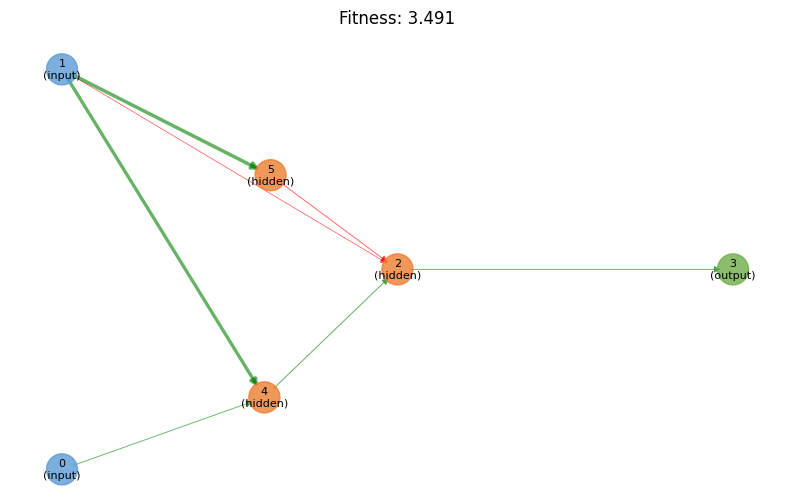

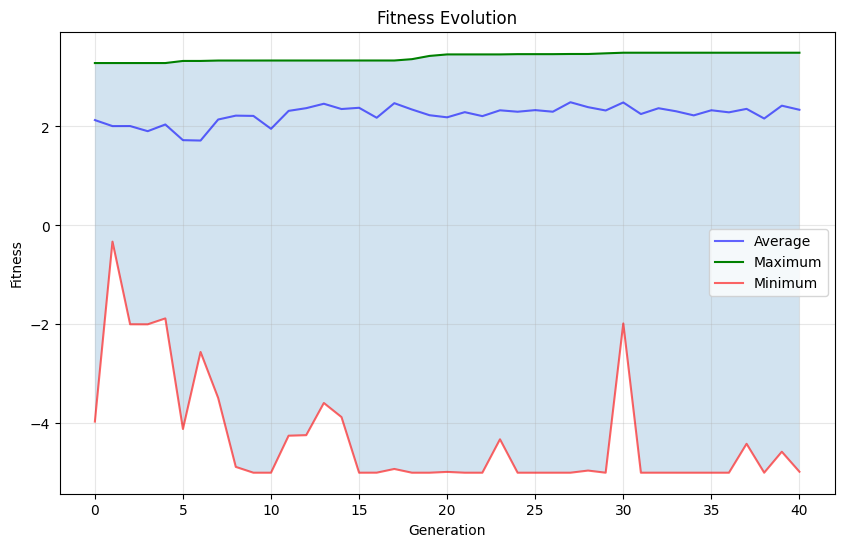


Final Analysis:


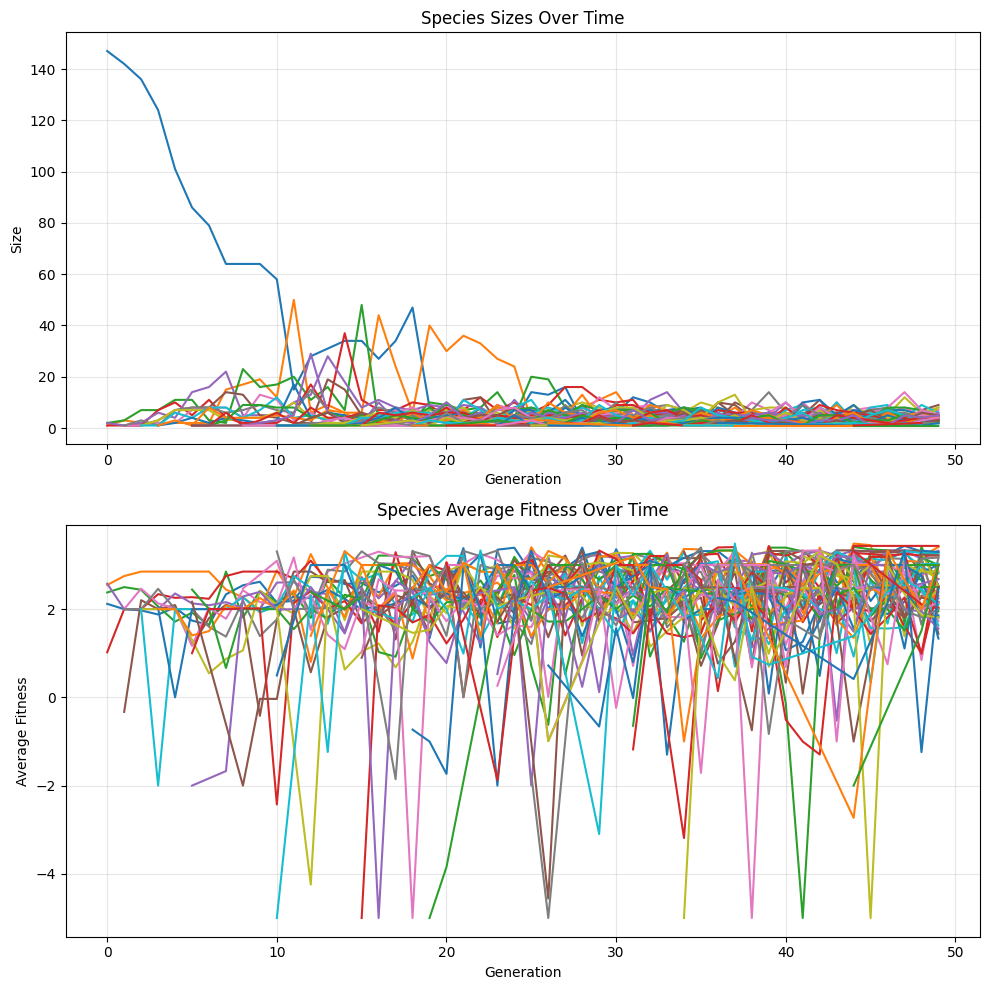


Best Solution Performance:
Input: [0. 0.], Expected: 0.0, Output: 0.000
Input: [0. 1.], Expected: 1.0, Output: 0.489
Input: [1. 0.], Expected: 1.0, Output: 0.944
Input: [1. 1.], Expected: 0.0, Output: 0.489

Final Network Visualization:


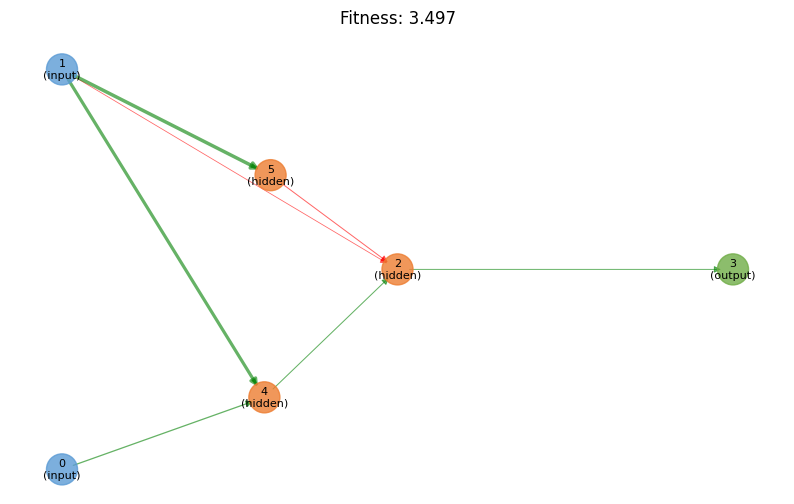

<Axes: title={'center': 'Fitness: 3.497'}>

In [21]:
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import clear_output
from typing import Dict, List, Tuple, Optional, Any
import json

class NetworkVisualizer:
    def __init__(self, size: Tuple[int, int] = (10, 6)):
        self.size = size

    def create_network_graph(self, genome: Genome) -> nx.DiGraph:
        """Creates a NetworkX graph from genome."""
        G = nx.DiGraph()

        # Add nodes with positions and colors
        for node_id, node in genome.nodes.items():
            color = {
                'input': '#5B9BD5',   # Blue
                'hidden': '#ED7D31',  # Orange
                'output': '#70AD47'   # Green
            }.get(node.type, 'gray')

            G.add_node(node_id,
                      pos=(node.x, node.y),
                      color=color,
                      node_type=node.type)

        # Add edges with weights determining thickness and color
        weights = [abs(c.weight) for c in genome.connections.values() if c.enabled]
        max_weight = max(weights) if weights else 1.0

        for conn in genome.connections.values():
            if conn.enabled:
                width = 0.5 + 2 * abs(conn.weight) / max_weight
                color = 'red' if conn.weight < 0 else 'green'
                G.add_edge(conn.in_node, conn.out_node,
                          weight=conn.weight,
                          width=width,
                          color=color)

        return G

    def draw_genome(self, genome: Genome, ax: Optional[plt.Axes] = None,
                   show: bool = True) -> Optional[plt.Axes]:
        """Visualizes genome as a neural network."""
        if ax is None:
            fig, ax = plt.subplots(figsize=self.size)

        G = self.create_network_graph(genome)
        pos = nx.get_node_attributes(G, 'pos')

        # Draw edges
        for (u, v, data) in G.edges(data=True):
            nx.draw_networkx_edges(G, pos,
                                 edgelist=[(u, v)],
                                 width=data['width'],
                                 edge_color=data['color'],
                                 alpha=0.6,
                                 ax=ax)

        # Draw nodes
        node_colors = [G.nodes[node]['color'] for node in G.nodes()]
        nx.draw_networkx_nodes(G, pos,
                             node_color=node_colors,
                             node_size=500,
                             alpha=0.8,
                             ax=ax)

        # Add labels
        labels = {node: f"{node}\n({G.nodes[node]['node_type']})"
                 for node in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels, font_size=8, ax=ax)

        ax.set_title(f"Fitness: {genome.fitness:.3f}")
        ax.set_axis_off()

        if show:
            plt.show()

        return ax

class EvolutionAnalytics:
    def __init__(self):
        self.reset()

    def reset(self) -> None:
        """Resets all analytics."""
        self.generation_stats = []
        self.species_stats = []
        self.best_genomes = []

    def record_generation(self, generation: int, population: List[Genome],
                         species: List[List[Genome]]) -> None:
        """Records statistics for current generation."""
        # Population stats
        fitnesses = [g.fitness for g in population]
        gen_stats = {
            'generation': generation,
            'avg_fitness': float(np.mean(fitnesses)),
            'max_fitness': float(np.max(fitnesses)),
            'min_fitness': float(np.min(fitnesses)),
            'std_fitness': float(np.std(fitnesses)),
            'population_size': len(population),
            'n_species': len(species)
        }
        self.generation_stats.append(gen_stats)

        # Species stats
        species_stats = []
        for i, s in enumerate(species):
            s_fitnesses = [g.fitness for g in s]
            stats = {
                'species_id': i,
                'size': len(s),
                'avg_fitness': float(np.mean(s_fitnesses)),
                'max_fitness': float(np.max(s_fitnesses)),
                'generation': generation
            }
            species_stats.append(stats)
        self.species_stats.append(species_stats)

        # Record best genome
        best_genome = max(population, key=lambda g: g.fitness)
        self.best_genomes.append((generation, best_genome))

    def plot_fitness_evolution(self, title: str = "Fitness Evolution") -> None:
        """Plots fitness evolution over generations."""
        generations = [s['generation'] for s in self.generation_stats]
        avg_fitness = [s['avg_fitness'] for s in self.generation_stats]
        max_fitness = [s['max_fitness'] for s in self.generation_stats]
        min_fitness = [s['min_fitness'] for s in self.generation_stats]

        plt.figure(figsize=(10, 6))
        plt.plot(generations, avg_fitness, label='Average', color='blue', alpha=0.6)
        plt.plot(generations, max_fitness, label='Maximum', color='green')
        plt.plot(generations, min_fitness, label='Minimum', color='red', alpha=0.6)
        plt.fill_between(generations, min_fitness, max_fitness, alpha=0.2)

        plt.title(title)
        plt.xlabel("Generation")
        plt.ylabel("Fitness")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_species_evolution(self) -> None:
        """Plots species size and fitness evolution."""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

        # Species sizes
        generations = sorted(set(s['generation'] for stats in self.species_stats
                               for s in stats))
        species_ids = sorted(set(s['species_id'] for stats in self.species_stats
                               for s in stats))

        for species_id in species_ids:
            sizes = []
            gens = []
            for gen in generations:
                size = next((s['size'] for stats in self.species_stats
                           for s in stats if s['generation'] == gen
                           and s['species_id'] == species_id), None)
                if size is not None:
                    sizes.append(size)
                    gens.append(gen)
            ax1.plot(gens, sizes, label=f'Species {species_id}')

        ax1.set_title("Species Sizes Over Time")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Size")
        #ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, alpha=0.3)

        # Species fitness
        for species_id in species_ids:
            fitnesses = []
            gens = []
            for gen in generations:
                fitness = next((s['avg_fitness'] for stats in self.species_stats
                              for s in stats if s['generation'] == gen
                              and s['species_id'] == species_id), None)
                if fitness is not None:
                    fitnesses.append(fitness)
                    gens.append(gen)
            ax2.plot(gens, fitnesses, label=f'Species {species_id}')

        ax2.set_title("Species Average Fitness Over Time")
        ax2.set_xlabel("Generation")
        ax2.set_ylabel("Average Fitness")
        #ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# Enhanced Population class with visualization
class EnhancedPopulation(Population):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.analytics = EvolutionAnalytics()
        self.visualizer = NetworkVisualizer()

    def evolve(self, initial_genome: Genome, generations: int,
               visualize_every: int = 10) -> Genome:
        """Evolves population with visualization and analytics."""
        try:
            # Create initial population
            population = self.create_initial_population(initial_genome)
            self.analytics.reset()

            best_genome = initial_genome  # Initialize best_genome
            best_fitness = float('-inf')

            for generation in range(generations):
                # Evaluate fitness
                for genome in population:
                    try:
                        genome.fitness = self.fitness_evaluator(genome)

                        # Update best genome
                        if genome.fitness > best_fitness:
                            best_fitness = genome.fitness
                            best_genome = genome
                    except Exception as e:
                        print(f"Error evaluating genome: {e}")
                        genome.fitness = 0.0

                # Speciate population
                species = self.species_manager.speciate(population)

                # Record analytics
                self.analytics.record_generation(generation, population, species)

                # Visualize progress
                if generation % visualize_every == 0:
                    clear_output(wait=True)
                    print(f"\nGeneration {generation}:")
                    print(f"Best Fitness: {best_fitness:.4f}")
                    print(f"Number of Species: {len(species)}")
                    print(f"Population Size: {len(population)}")

                    try:
                        # Plot current best network
                        self.visualizer.draw_genome(best_genome)

                        # Plot fitness evolution
                        self.analytics.plot_fitness_evolution()
                    except Exception as e:
                        print(f"Visualization error: {e}")

                # Evolution step
                #self.compute_adjusted_fitness(species)
                new_population = self.selection(species)

                # Verify new population
                if not new_population:
                    raise ValueError("Selection produced empty population")

                population = new_population
                self.generation += 1

            return best_genome

        except Exception as e:
            print(f"Evolution error: {e}")
            return initial_genome  # Return initial genome if evolution fails

# Test the enhanced evolution
print("Creating initial genome...")
initial_genome = genome  # Using previously created XOR network

print("Initializing evolution...")
enhanced_population = EnhancedPopulation(
    innovation_tracker, mutation_params, evolution_params,
    species_manager, xor_fitness
)

print("Starting evolution...")
best_genome = enhanced_population.evolve(initial_genome, generations=50, visualize_every=10)

print("\nFinal Analysis:")
enhanced_population.analytics.plot_species_evolution()

print("\nBest Solution Performance:")
test_cases = [
    (np.array([0., 0.]), 0.),
    (np.array([0., 1.]), 1.),
    (np.array([1., 0.]), 1.),
    (np.array([1., 1.]), 0.)
]

for inputs, expected in test_cases:
    output = best_genome.feedforward(inputs)
    print(f"Input: {inputs}, Expected: {expected:.1f}, Output: {output[0]:.3f}")

print("\nFinal Network Visualization:")
enhanced_population.visualizer.draw_genome(best_genome)

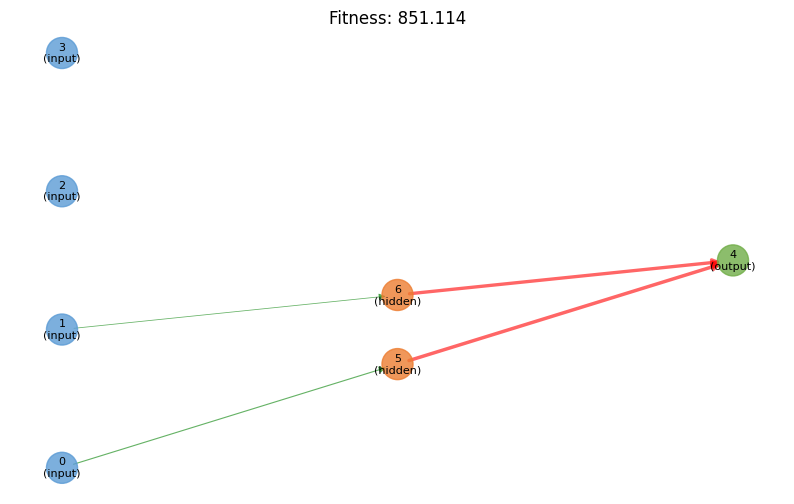

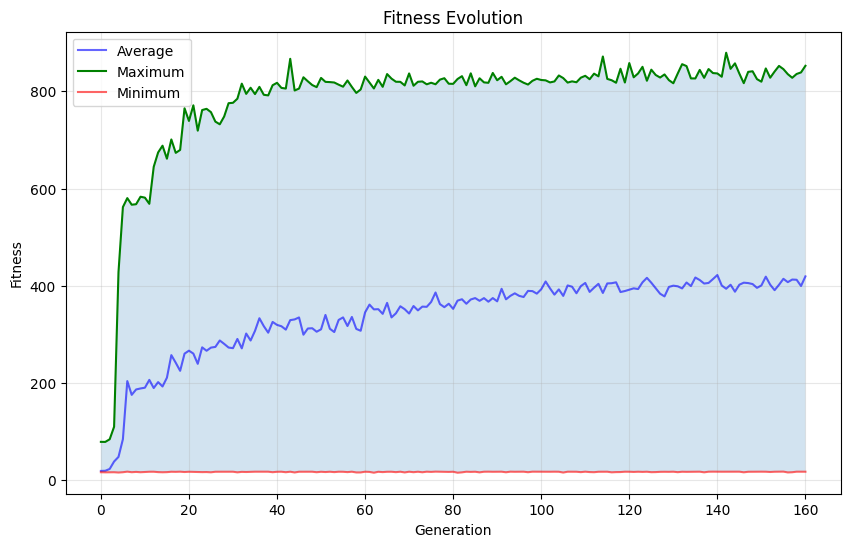

In [ ]:
import numpy as np
from typing import Tuple, Optional, Dict, List, Set
import random
from dataclasses import dataclass
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle, Circle

@dataclass
class CartPoleParams:
    # Basic physics parameters
    gravity: float = 9.8
    cart_mass: float = 1.0
    pole_mass: float = 0.1
    pole_length: float = 0.5  # Half the pole's actual length
    force_mag: float = 10.0
    tau: float = 0.02  # Time step

    # Boundaries
    x_threshold: float = 2.4
    theta_threshold: float = 12 * np.pi / 180  # 12 degrees

    # Disturbance parameters
    wind_force: float = 1.0
    wind_change_prob: float = 0.02
    shock_force: float = 15.0
    shock_prob: float = 0.01

class CartPole:
    def __init__(self, params: Optional[CartPoleParams] = None):
        self.params = params or CartPoleParams()
        self.state = None
        self.steps = 0
        self.max_steps = 1000  # Increased to give more time for swing-up
        self.current_wind = 0.0
        self.disturbance_history = []
        self.upright_steps = 0  # Track how long it stays upright

    def reset(self) -> np.ndarray:
        """Reset with pole pointing down (pi radians) with small random perturbation."""
        self.state = np.array([
            np.random.uniform(-0.05, 0.05),  # x position
            np.random.uniform(-0.05, 0.05),  # x velocity
            np.pi + np.random.uniform(-0.05, 0.05),  # theta (pi = pointing down)
            np.random.uniform(-0.05, 0.05)   # theta velocity
        ])
        self.steps = 0
        self.current_wind = 0.0
        self.disturbance_history = []
        return self.state.copy()

    def step(self, action: int) -> Tuple[np.ndarray, float, bool]:
        assert self.state is not None, "Call reset() before step()"

        x, x_dot, theta, theta_dot = self.state

        # Base force from action
        force = self.params.force_mag if action == 1 else -self.params.force_mag

        # Update wind force
        if random.random() < self.params.wind_change_prob:
            self.current_wind = random.uniform(-self.params.wind_force, self.params.wind_force)

        # Add random shock
        shock = 0.0
        if random.random() < self.params.shock_prob:
            shock = random.uniform(-self.params.shock_force, self.params.shock_force)

        # Record disturbances
        self.disturbance_history.append({
            'step': self.steps,
            'wind': self.current_wind,
            'shock': shock
        })

        # Apply all forces
        force = force + self.current_wind + shock

        # Shortcuts for readability
        g = self.params.gravity
        m = self.params.cart_mass
        M = self.params.pole_mass
        l = self.params.pole_length
        tau = self.params.tau

        # Calculate acceleration using physics equations
        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)

        # Helper terms
        temp = (force + M * l * theta_dot**2 * sin_theta) / (m + M)
        temp2 = (g * sin_theta - cos_theta * temp) / (l * (4/3 - M * cos_theta**2 / (m + M)))

        # Calculate accelerations
        x_acc = temp - M * l * temp2 * cos_theta / (m + M)
        theta_acc = temp2

        # Update state using Euler integration
        x_dot = x_dot + tau * x_acc
        x = x + tau * x_dot
        theta_dot = theta_dot + tau * theta_acc
        theta = theta + tau * theta_dot

        self.state = np.array([x, x_dot, theta, theta_dot])
        self.steps += 1

        # Normalize theta to [-pi, pi] range
        theta = ((theta + np.pi) % (2 * np.pi)) - np.pi

        # Check termination conditions
        done = (
            x < -self.params.x_threshold or
            x > self.params.x_threshold or
            self.steps >= self.max_steps
        )

        # Base reward - just for surviving
        reward = 0.1

        # Reward shaping for swing-up behavior
        upright_angle = 0  # The target angle (upright position)
        angle_diff = abs(theta - upright_angle)

        # Higher reward when closer to upright position
        angle_reward = (np.pi - angle_diff) / np.pi  # Normalized to [0, 1]
        reward += angle_reward

        # Small reward for being in motion when not upright (to encourage swinging)
        if angle_diff > np.pi/2:
            reward += abs(theta_dot) * 0.1

        # Bonus for staying close to upright position
        if angle_diff < 0.1:  # About 5.7 degrees from vertical
            reward += 2.0

        # Early termination bonus if it stays upright for a while
        if self.steps > 100 and angle_diff < 0.1:
            reward += 5.0
            done = True

        # Clip minimum reward to ensure positive values
        reward = max(0.1, reward)

        return self.state.copy(), reward, done

class CartPoleVisualizer:
    def __init__(self, env: CartPole):
        self.env = env

    def create_animation(self, genome: Genome, filename: str = 'cartpole.gif'):
        # Set up the figure
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(111)
        ax.set_xlim(-self.env.params.x_threshold*1.2, self.env.params.x_threshold*1.2)
        ax.set_ylim(-1, 1.5)

        # Initialize cart and pole graphics
        cart_width = 0.3
        cart_height = 0.2
        pole_length = self.env.params.pole_length * 2  # Full length

        cart = Rectangle((0, -cart_height/2), cart_width, cart_height, fill=True, color='blue')
        pole = Rectangle((cart_width/2, 0), 0.1, pole_length, fill=True, color='red')

        # Text displays
        time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
        force_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)

        # Add graphics to axes
        ax.add_patch(cart)
        ax.add_patch(pole)

        # Ground line
        ax.plot([-self.env.params.x_threshold*1.2, self.env.params.x_threshold*1.2],
                [-cart_height/2, -cart_height/2], 'k-', lw=1)

        def init():
            return cart, pole, time_text, force_text

        def animate(i):
            if i == 0:
                self.env.reset()

            # Get action from neural network
            state = self.env.state
            network_output = genome.feedforward(state)
            action = 1 if network_output[0] > 0.5 else 0

            # Take step in environment
            state, _, done = self.env.step(action)

            if done:
                return cart, pole, time_text, force_text

            # Update cart position
            cart_x = state[0]
            cart.set_x(cart_x - cart_width/2)

            # Update pole angle
            pole_angle = state[2]
            pole_x = cart_x + cart_width/2
            pole_y = 0

            # Transform pole
            transform = plt.matplotlib.transforms.Affine2D().rotate_around(
                pole_x, pole_y, pole_angle)
            pole.set_transform(transform + ax.transData)
            pole.set_x(pole_x - 0.05)  # Center pole on cart

            # Update text displays
            time_text.set_text(f'Time: {i*self.env.params.tau:.1f}s')
            force_text.set_text(f'Wind: {self.env.current_wind:.1f}N')

            return cart, pole, time_text, force_text

        # Create animation
        anim = animation.FuncAnimation(fig, animate, init_func=init,
                                     frames=self.env.max_steps,
                                     interval=self.env.params.tau*1000,
                                     blit=True)

        # Save animation
        anim.save(filename, writer='pillow')
        plt.close()

def cartpole_fitness(genome: Genome) -> float:
    """Fitness function for CartPole using NEAT."""
    env = CartPole(CartPoleParams(
        wind_force=1.0,  # Reduced initially to make learning easier
        wind_change_prob=0.02,
        shock_force=10.0,
        shock_prob=0.01,
        force_mag=20.0  # Increased to help with swing-up
    ))
    total_reward = 0
    n_episodes = 3  # Reduced episodes since each one is longer now

    for _ in range(n_episodes):
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            network_output = genome.feedforward(state)
            action = 1 if network_output[0] > 0.5 else 0
            next_state, reward, done = env.step(action)
            episode_reward += reward
            state = next_state

        total_reward += episode_reward

    return total_reward / n_episodes

def create_cartpole_genome() -> Genome:
    """Creates initial genome structure for CartPole."""
    nodes = {
        0: NodeGene(0, 'input', x=0.0, y=0.0),   # x position
        1: NodeGene(1, 'input', x=0.0, y=0.2),   # x velocity
        2: NodeGene(2, 'input', x=0.0, y=0.4),   # pole angle
        3: NodeGene(3, 'input', x=0.0, y=0.6),   # pole angular velocity
        4: NodeGene(4, 'output', x=1.0, y=0.3)   # action (left/right)
    }

    connections = {
        (0, 4): ConnectionGene(0, 4, random.uniform(-1, 1)),
        (1, 4): ConnectionGene(1, 4, random.uniform(-1, 1)),
        (2, 4): ConnectionGene(2, 4, random.uniform(-1, 1)),
        (3, 4): ConnectionGene(3, 4, random.uniform(-1, 1))
    }

    return Genome(nodes, connections)

# Main execution
if __name__ == "__main__":
    # Initialize NEAT components
    cartpole_genome = create_cartpole_genome()
    innovation_tracker = InnovationTracker()

    # Configure evolution parameters
    evolution_params = EvolutionParams(
        population_size=200,  # Increased population size for harder task
        survival_threshold=0.2,
        interspecies_mating_rate=0.002,  # Slightly increased for more exploration
        elitism=3  # Increased to preserve good solutions
    )

    mutation_params = MutationParams(
        weight_mutation_rate=0.8,
        weight_perturbation_rate=0.9,
        new_node_rate=0.03,
        new_connection_rate=0.05,
        weight_init_range=2.0
    )

    species_manager = SpeciesManager(
        compatibility_threshold=3.0,
        c1=1.0,
        c2=1.0,
        c3=0.4
    )

    # Initialize population
    enhanced_population = EnhancedPopulation(
        innovation_tracker,
        mutation_params,
        evolution_params,
        species_manager,
        cartpole_fitness
    )

    # Run evolution
    print("Starting CartPole evolution...")
    best_genome = enhanced_population.evolve(
        cartpole_genome,
        generations=200,
        visualize_every=5
    )

    # Create animation of best genome
    print("\nCreating animation of best genome...")
    env = CartPole()
    visualizer = CartPoleVisualizer(env)
    visualizer.create_animation(best_genome, 'best_cartpole.gif')
    print("Animation saved as 'best_cartpole.gif'")

    # Final performance statistics
    print("\nFinal Statistics:")
    print(f"Best fitness achieved: {best_genome.fitness}")
    print(f"Number of nodes: {len(best_genome.nodes)}")
    print(f"Number of connections: {len(best_genome.connections)}")